In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def random_orthogonal_basis(k, attack=False):
    """
    Generates a random orthogonal basis for R^k.

    Parameters:
    k (int): Dimension of the space.

    Returns:
    np.ndarray: A k x k orthogonal matrix whose columns form an orthogonal basis.
    """
    # Generate a random k x k matrix with entries from a standard normal distribution
    A = np.random.randn(k, k)
    if attack:
        # correct A to start with the cursed vector
        A[:,0] = -np.ones(k)
        A[0,0] = k**(1/2)
        A = A.T
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

def gram_schmidt(A):
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

# Example usage:
k = 100  # Dimension of the space
basis = random_orthogonal_basis(k)
print(f"Random orthogonal basis for R^{k}:")

Random orthogonal basis for R^100:


In [18]:
def inf(matrix):
    """
    Computes the infinity norm of a matrix.

    Parameters:
    matrix (array-like): A 2D list or NumPy array representing the matrix.

    Returns:
    float: The infinity norm of the matrix.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix)
    
    # Compute the infinity norm
    
    infinity_norm = np.sort(np.sum(np.abs(matrix), axis=1))[int(k-1)] #np.max(np.sum(np.abs(matrix), axis=1))
    return infinity_norm

In [5]:
def get_fourier(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = np.cos(i*x)/(k**0.5)
    return mat

def get_poly(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = x**i/(k**0.5)
    return mat


KeyboardInterrupt: 

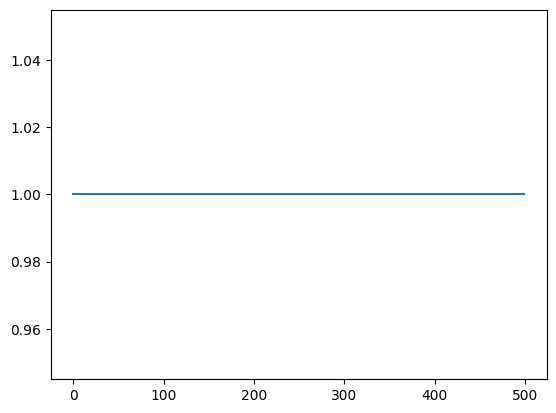

In [6]:
k = 500
x = np.arange(k)
basis_stand = np.identity(k)
basis_four = gram_schmidt(get_fourier(k))
basis_poly = gram_schmidt(get_poly(k))
basis_rand = random_orthogonal_basis(k)
basis_evil = random_orthogonal_basis(k, attack=True)

basis_list = [basis_stand, basis_four, basis_poly, basis_rand, basis_evil]
labels = ['stand', 'four', 'poly', 'rand', 'evil']

for i in range(len(basis_list)):   

    # choose the basis
    basis = basis_list[i] 
    mat = np.zeros((k,k))

    # infnorms collects the infinity norm of the matrices
    infnorms = np.zeros(k)

    for d in range(k):

        # we incrementally update the matrix adding more and more basis functions
        mat += np.dot(basis[:,d:d+1], basis[:,d:d+1].T)
        infnorms[d] = inf(mat)

    plt.plot(x, infnorms, label = labels[i])


plt.legend()
plt.xlabel('dimension of the projection space')
plt.ylabel('infinity norm')
plt.show()

In [35]:
def test_submodularity(basis, iter=1000):
    k = basis.shape[1]
    maxim = -100
    for i in range(iter):
        mat = []
        vec = []
        rs = np.random.choice(k,size=3,replace=False)

        for i in range(3):
            r = rs[i]
            vec.append(basis[:,r])
            mat.append(np.dot(basis[:,r:r+1], basis[:,r:r+1].T))
        
        z = inf(mat[0]+mat[1]+mat[2]) - inf(mat[0]+mat[1]) - inf(mat[0]+mat[2]) + inf(mat[0])
        if z > maxim:
            maxim = z
            retvecs = vec
    
    return maxim, retvecs
        


In [36]:
k = 4
vecs = []
maxim = 0
for _ in range(1000):
    basis = random_orthogonal_basis(k)
    z, vecs = test_submodularity(basis, iter=min(1000,k**3))
    if z > maxim:
        retvecs = vecs
        maxim = z


In [36]:
## create random basis of dimension k
k = 200
d = 50
basis = random_orthogonal_basis(k)
starting_matrix = np.dot(basis[:,:d],basis[:,:d].T)
print(inf(starting_matrix))

5.862956939070147


In [7]:
## this time we add, at each time, the matrix which maked the infinity norm smaller

def choose_f(M, vectors):
    mio = 100000
    idx = 0
    for i in range(vectors.shape[1]):
        v = vectors[:,i:i+1]
        info = inf(M+np.dot(v,v.T))
        if info < mio:
            mio = info
            idx = i
    return idx, info

def build_low_mat(basis, d):
    idx = 0
    M = np.zeros((basis.shape[0],basis.shape[0]))
    residual = np.copy(basis)
    for i in range(d):
        v = residual[:,idx:idx+1]
        M += np.dot(v,v.T)
        residual = np.hstack((residual[:,:idx], residual[:,idx+1:]))
        idx, info = choose_f(M, residual)
    return info

k = 200
d = 100
basis = random_orthogonal_basis(k)


starting_matrix = np.dot(basis[:,:d],basis[:,:d].T)
print(inf(starting_matrix))
print(build_low_mat(basis, d))

6.4423933847542925
6.271312915422958


In [11]:


def compute_w_proj(V,W):

    # compute inner matrix that is going to be inverted
    Inner = np.dot(V.T,np.dot(W,V))
    In = np.linalg.inv(Inner)

    # compute actual projection matrix
    P = np.dot(np.dot(V, np.dot(In, V.T)), W)
    return P

def matrix_derivarive(V, W):

    # compute inner matrix that is going to be inverted
    Inner = np.dot(V.T,np.dot(W,V))
    In = np.linalg.inv(Inner)

    # compute actual projection matrix
    P = np.dot(np.dot(V, np.dot(In, V.T)), W)

    
    return P

In [9]:
W = np.eye(k)/k

compute_w_proj(basis, W).shape

(200, 200)

In [35]:
# test convexity. We choose some data distribution to show that the 
# weighted infinity norm is *not* a convex function of the (vector-valued) input
import numpy as np

def test_conv(f, d, samp=1000):
    rands = np.random.uniform(size=(samp,d))
    sums = np.sum(rands, axis=1)
    sums = sums[:, np.newaxis]
    rands = rands/sums

    fvec = np.zeros(samp)
    fvec[0] = f(rands[0,:])

    for i in range(samp-1):
        fvec[i+1] = f(rands[i+1,:])

        mean = (rands[i] + rands[i+1])/2
        if f(mean) > (fvec[i] + fvec[i+1])/2:
            print(f(mean) - (fvec[i] + fvec[i+1])/2)
            return False
    
    return True

def fun(x):
    return x[0] + x[1] + x[1]**2

test_conv(fun, 2)


True

In [44]:
#### define the function giving the effectiveness of every data distribution
k = 100
d = 30
basis = random_orthogonal_basis(k=k)

# orthogonal matrix
V = basis[:,:d]

def compute_w_proj(V,W):

    # compute inner matrix that is going to be inverted
    Inner = np.dot(V.T,np.dot(W,V))
    In = np.linalg.inv(Inner)

    # compute actual projection matrix
    P = np.dot(np.dot(V, np.dot(In, V.T)), W)
    return P


# mu given distribution on the k elelments
def optimizer(w):
    W = np.diag(w)
    Mat = compute_w_proj(V,W)
    return inf(Mat)
    

In [45]:
test_conv(optimizer, d=k)

True